# Dataloader

In [1]:
import torch
import numpy as np
import torch.nn as nn
from roi_data_layer.roidb import combined_roidb
from torch.utils.data.sampler import Sampler
from roi_data_layer.roibatchLoader import roibatchLoader
import matplotlib.pyplot as plt

class sampler(Sampler):
    def __init__(self, train_size, batch_size):
        self.num_data = train_size
        self.num_per_batch = int(train_size / batch_size)
        self.batch_size = batch_size
        self.range = torch.arange(0,batch_size).view(1, batch_size).long()
        self.leftover_flag = False
        if train_size % batch_size:
            self.leftover = torch.arange(self.num_per_batch*batch_size, train_size).long()
            self.leftover_flag = True

    def __iter__(self):
        rand_num = torch.randperm(self.num_per_batch).view(-1,1) * self.batch_size
        self.rand_num = rand_num.expand(self.num_per_batch, self.batch_size) + self.range

        self.rand_num_view = self.rand_num.view(-1)

        if self.leftover_flag:
            self.rand_num_view = torch.cat((self.rand_num_view, self.leftover),0)

        return iter(self.rand_num_view)

    def __len__(self):
        
        return self.num_data

imdb_name = "voc_2007_trainval"
imdbval_name = "voc_2007_test"
batch_size = 4
num_workers = 8

imdb, roidb, ratio_list, ratio_index = combined_roidb(imdb_name)

train_size = len(roidb)

sampler_batch = sampler(train_size, batch_size)

dataset = roibatchLoader(roidb, ratio_list, ratio_index, batch_size, \
                       imdb.num_classes, training=True)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                        sampler=sampler_batch, num_workers=num_workers)

batch = next(iter(dataloader))

Loaded dataset `voc_2007_trainval` for training
Set proposal method: gt
Appending horizontally-flipped training examples...
voc_2007_trainval gt roidb loaded from /tf/faster-rcnn.pytorch/data/cache/voc_2007_trainval_gt_roidb.pkl
done
Preparing training data...
done
before filtering, there are 10022 images...
after filtering, there are 10022 images...


### Batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


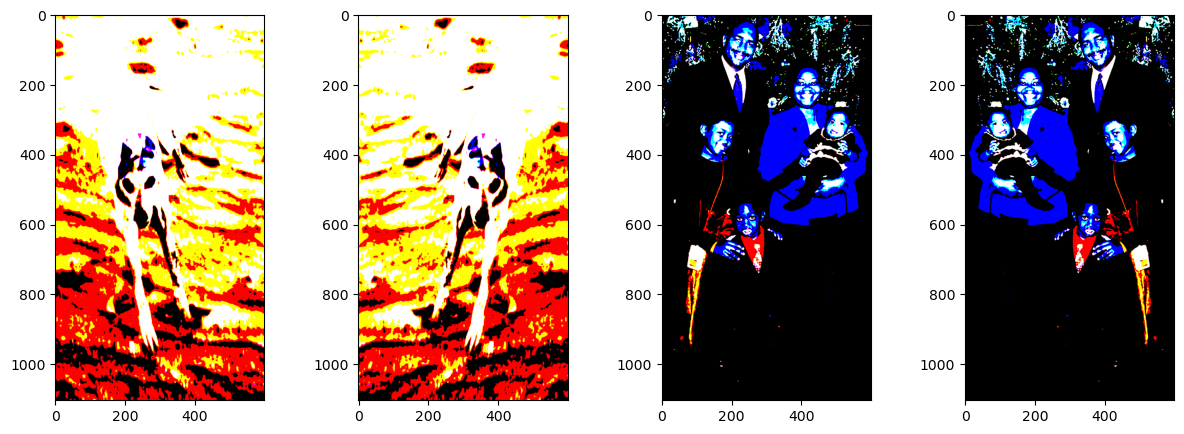

In [2]:
# batch[0]: input image -> (3, H, W)
# batch[0].shape = (B, 3, H, W)

img1, img2, img3, img4 = batch[0][0], batch[0][1], batch[0][2], batch[0][3]

fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(img1.permute(1, 2, 0).numpy())

ax2 = fig.add_subplot(1, 4, 2)
ax2.imshow(img2.permute(1, 2, 0).numpy())

ax3 = fig.add_subplot(1, 4, 3)
ax3.imshow(img3.permute(1, 2, 0).numpy())

ax4 = fig.add_subplot(1, 4, 4)
ax4.imshow(img4.permute(1, 2, 0).numpy())

In [3]:
# batch[1]: image information -> resolution (h, w) + ?
# batch[1].shape = (B, 3)

batch[1]

tensor([[1104.0000,  600.0000,    3.0000],
        [1104.0000,  600.0000,    3.0000],
        [1104.0000,  600.0000,    2.1978],
        [1104.0000,  600.0000,    2.1978]])

In [4]:
# batch[2]: ground-truth bboxes -> (x1, y1, x2, y2) + ?
# batch[2].shape = (B, 20, 5)

batch[2]

tensor([[[ 123.0000,  165.0000,  531.0000,  981.0000,   12.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
         [

In [5]:
batch[2].shape

torch.Size([4, 20, 5])

In [6]:
# batch[3]: number of ground-truth bboxes
# batch[3].shape = (B,)

batch[3]

tensor([1, 1, 5, 5])

# Backbone: VGG-16

In [29]:
import torchvision.models as models
from torchsummary import summary

vgg = models.vgg16()
vgg.classifier = nn.Sequential(*list(vgg.classifier._modules.values())[:-1])
RCNN_base = nn.Sequential(*list(vgg.features._modules.values())[:-1])
RCNN_base.to(torch.device('cuda'))

summary(RCNN_base, (3, 600, 600))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 600, 600]           1,792
              ReLU-2         [-1, 64, 600, 600]               0
            Conv2d-3         [-1, 64, 600, 600]          36,928
              ReLU-4         [-1, 64, 600, 600]               0
         MaxPool2d-5         [-1, 64, 300, 300]               0
            Conv2d-6        [-1, 128, 300, 300]          73,856
              ReLU-7        [-1, 128, 300, 300]               0
            Conv2d-8        [-1, 128, 300, 300]         147,584
              ReLU-9        [-1, 128, 300, 300]               0
        MaxPool2d-10        [-1, 128, 150, 150]               0
           Conv2d-11        [-1, 256, 150, 150]         295,168
             ReLU-12        [-1, 256, 150, 150]               0
           Conv2d-13        [-1, 256, 150, 150]         590,080
             ReLU-14        [-1, 256, 1

In [30]:
vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
)

- input: 3x600x600 -> output: 512x37x37

# Anchors

In [7]:
try:
    xrange          # Python 2
except NameError:
    xrange = range  # Python 3


def generate_anchors(base_size=16, ratios=[0.5, 1, 2],
                     scales=2**np.arange(3, 6)):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales wrt a reference (0, 0, 15, 15) window.
    """

    base_anchor = np.array([1, 1, base_size, base_size]) - 1
    ratio_anchors = _ratio_enum(base_anchor, ratios)
    anchors = np.vstack([_scale_enum(ratio_anchors[i, :], scales)
                         for i in xrange(ratio_anchors.shape[0])])
    return anchors

def _whctrs(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """

    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr

def _mkanchors(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center
    (x_ctr, y_ctr), output a set of anchors (windows).
    """

    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack((x_ctr - 0.5 * (ws - 1),
                         y_ctr - 0.5 * (hs - 1),
                         x_ctr + 0.5 * (ws - 1),
                         y_ctr + 0.5 * (hs - 1)))
    return anchors

def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def _scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    ws = w * scales
    hs = h * scales
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

In [8]:
anchors = generate_anchors()
anchors.shape

(9, 4)

In [9]:
anchors

array([[ -84.,  -40.,   99.,   55.],
       [-176.,  -88.,  191.,  103.],
       [-360., -184.,  375.,  199.],
       [ -56.,  -56.,   71.,   71.],
       [-120., -120.,  135.,  135.],
       [-248., -248.,  263.,  263.],
       [ -36.,  -80.,   51.,   95.],
       [ -80., -168.,   95.,  183.],
       [-168., -344.,  183.,  359.]])

In [10]:
feat_width = 37
feat_height = 37
_feat_stride = 16
shift_x = np.arange(0, feat_width) * _feat_stride
shift_y = np.arange(0, feat_height) * _feat_stride
shift_x, shift_y = np.meshgrid(shift_x, shift_y)
shift_x.shape

(37, 37)

In [11]:
shifts = torch.from_numpy(np.vstack((shift_x.ravel(), shift_y.ravel(),
                                  shift_x.ravel(), shift_y.ravel())).transpose())

shifts.shape

torch.Size([1369, 4])

In [12]:
shifts

tensor([[  0,   0,   0,   0],
        [ 16,   0,  16,   0],
        [ 32,   0,  32,   0],
        ...,
        [544, 576, 544, 576],
        [560, 576, 560, 576],
        [576, 576, 576, 576]])

In [13]:
torch.rand((32, 12321, 4))[:,:,3::4].shape

torch.Size([32, 12321, 1])

In [14]:
batch[1]

tensor([[600.0000, 800.0000,   1.6000],
        [600.0000, 800.0000,   1.6000],
        [600.0000, 800.0000,   1.6000],
        [600.0000, 800.0000,   1.6000]])

In [15]:
torch.rand((20, 4)).dim()

2

In [16]:
a = torch.rand((20, 4))
b = torch.rand((20, 4))

In [17]:
torch.stack((a, b), 2).shape

torch.Size([20, 4, 2])

In [18]:
torch.Tensor(13, 2).fill_(-1)

tensor([[-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.],
        [-1., -1.]])

In [19]:
a = torch.rand((13, 2))
b = torch.randint(0, 2, (13,))

In [20]:
import torch.nn.functional as F

F.cross_entropy(a, b)

tensor(0.6749)

In [24]:
np.random.rand(128) * 36

array([16.63412849, 12.53557223,  3.1180421 , 33.30325464, 21.14420504,
       29.67064874,  7.18953562, 17.69967569, 19.22607788, 14.59964266,
       26.42990543, 22.44862406, 16.52085237, 16.45956722, 17.78375782,
       13.67323039, 35.76251684, 19.44790171, 30.07907356,  5.8989723 ,
       11.51501976, 33.20255111,  5.27345877, 13.21413044, 21.23090898,
        4.00779782, 16.65998853,  0.3344336 , 17.26651427, 28.34079835,
        2.57766358,  4.79700799, 11.59575237, 20.06849177, 28.74975358,
        4.47556117, 19.50433675, 21.55746596, 22.78518751, 10.36401297,
        3.15370978, 26.98047043,  7.16273036,  2.5781543 , 25.72513825,
        5.39642568, 13.48112206, 18.80021556, 27.14031128,  7.09252154,
        1.61600312, 32.80305176,  5.90437301, 13.83771361, 34.11339943,
       12.60528109, 17.75417195, 35.74059903, 33.04875552, 16.05284838,
       31.55949995, 35.29808711, 11.0371756 , 20.76678037,  3.39224443,
       21.52872548, 17.62185783,  4.28945727, 27.15753557,  7.35

In [25]:
a = torch.rand((128, 5))

In [28]:
torch.split(a, 1, dim=1)[0].shape

torch.Size([128, 1])

In [45]:
gt_boxes = torch.randint(0, 21, (4, 20, 5))
gt_assignment = torch.randint(0, 20, (batch_size, 2020))
batch_size = 4
offset = torch.arange(0, batch_size)*gt_boxes.size(1)
offset = offset.view(-1, 1).type_as(gt_assignment) + gt_assignment

In [35]:
labels = gt_boxes[:,:,4].contiguous().view(-1)[(offset.view(-1),)].view(batch_size, -1)
labels.shape

torch.Size([4, 2020])

In [54]:
labels.min()

tensor(0)

In [50]:
gt_boxes[:,:,4].contiguous().view(-1)

tensor([16,  3, 18, 12,  4,  6,  9,  5, 19,  6,  3, 20,  4,  4, 18,  2, 20, 10,
         5, 14,  6,  2, 13,  9,  2,  9,  5, 14, 17,  9,  1, 20,  3,  8, 20,  0,
         9, 16, 14,  2, 19,  5,  1,  1,  6,  9, 16, 18,  5,  8,  0, 18,  6, 20,
         4,  0,  7,  9,  1, 19, 12, 13, 10,  8, 17, 14,  8, 20,  3,  8,  4, 18,
         1, 12, 16,  6, 17, 13,  4,  7])

In [52]:
gt_assignment[1].shape

torch.Size([2020])

In [61]:
rois_label = torch.randint(0, 21, (512,))

In [70]:
bbox_pred = torch.rand((512, 84))

In [71]:
bbox_pred.shape

torch.Size([512, 84])

In [72]:
rois_label.shape

torch.Size([512])

In [73]:
bbox_pred_view = bbox_pred.view(bbox_pred.size(0), int(bbox_pred.size(1) / 4), 4)

In [74]:
bbox_pred_view.shape

torch.Size([512, 21, 4])

In [75]:
bbox_pred_select = torch.gather(bbox_pred_view, 1, rois_label.view(rois_label.size(0), 1, 1).expand(rois_label.size(0), 1, 4))

In [76]:
bbox_pred_select.shape

torch.Size([512, 1, 4])

In [77]:
rois_label.view(rois_label.size(0), 1, 1).expand(rois_label.size(0), 1, 4).shape

torch.Size([512, 1, 4])

In [81]:
import torch.nn.functional as F

a = F.cross_entropy(torch.rand((512, 21)), torch.randint(0, 20, (512,)))


In [83]:
a

tensor(3.0852)